In [1]:
!pip install farm-haystack[inference]

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.0/764.0 kB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 164.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 172.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 187.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 123.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.6/736.6 kB 119.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 129.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/

In [2]:
!pip install farm-haystack[elasticsearch] #elasticsearch7 or elasticsearch8, defaults to 8

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.0/386.0 kB 63.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [23]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [9]:
import pandas as pd

# Dataset

In [6]:
import json
import os

# First, display the structure of the JSON file.
with open('Dell_QA_200.json', 'r') as file:
    data = json.load(file)
    print(json.dumps(data, indent=4))  # Pretty-printing the dictionary to visualize it.

# Then, rename the file.
#os.rename('answers (1).json', 'subjqa.json')


{
    "data": [
        {
            "paragraphs": [
                {
                    "qas": [
                        {
                            "question": "Does v9 license works with v8 platform?When I try to import the v9 license I am having this error. LIC017.\u00a0",
                            "id": 1082044,
                            "answers": [
                                {
                                    "answer_id": 980739,
                                    "document_id": 1619992,
                                    "question_id": 1082044,
                                    "text": "IDRAC v9 license is not compatible with iDRAC V8 platforms.",
                                    "answer_start": 0,
                                    "answer_end": 59,
                                    "answer_category": null
                                }
                            ],
                            "is_impossible": false
                        }
    

In [10]:
# Create a list to store the rows
rows = []

# Navigate the nested structure
for dat in data['data']:
    for paragraph in dat['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            for answer in qa['answers']:
                answer_text = answer['text']
                answer_start = answer['answer_start']
                # Append the row to the list
                rows.append([question, answer_text, answer_start, context])

# Create DataFrame
df = pd.DataFrame(rows, columns=['question', 'answers.text', 'answers.answer_start', 'context'])



In [11]:
df.head()

,question,answers.text,answers.answer_start,context
0,Does v9 license works with v8 platform?When I ...,IDRAC v9 license is not compatible with iDRAC ...,0,IDRAC v9 license is not compatible with iDRAC ...
1,Greetings! I got a hardware key labeled iSCSI ...,TOE is a standard feature of the LAN on Mother...,17,HelloI show that TOE is a standard feature of ...
2,A friend gave me an R730xd. It was working fin...,start with trying the servers minimum to post ...,24,"Curley83475824, I would start with trying the ..."
3,A 4-server VRTX was shipped to us that already...,Page 9 installation procedure - https://dell.t...,296,"Hello thisisalloneword, While you have access ..."
4,ADD 4GB RDIMM MEMORY AND DO NOT RECOGNIZE ME W...,Here is the list of Dell PN# for 4G UDIMM: ...,4,"Hi, Here is the list of Dell PN# for 4G UDIMM:..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   question              181 non-null    object
 1   answers.text          181 non-null    object
 2   answers.answer_start  181 non-null    int64 
 3   context               181 non-null    object
dtypes: int64(1), object(3)
memory usage: 5.8+ KB


## Train/Test split?

In [9]:
import json
import random

# Load the dataset from the JSON file
with open('Dell_QA_200.json', 'r') as f:
    squad_data = json.load(f)

# Assuming your JSON data is structured as a dictionary with a "data" key containing a list of examples.

# Shuffle the examples to randomize their order
random.shuffle(squad_data["data"])

# Calculate the number of examples for training and testing (80% train, 20% test)
train_size = int(0.8 * len(squad_data["data"]))
test_size = len(squad_data["data"]) - train_size

# Split the dataset into train and test sets
train_data = squad_data["data"][:train_size]
test_data = squad_data["data"][train_size:]

# Create new dictionaries for the "train" and "test" splits
train_split = {"data": train_data}
test_split = {"data": test_data}

# Save the train and test splits to separate JSON files if needed
with open('Dell_QA_200_train.json', 'w') as train_file:
    json.dump(train_split, train_file)
    
with open('Dell_QA_200_test.json', 'w') as test_file:
    json.dump(test_split, test_file)


In [10]:
len(test_split)

1

In [11]:
len(test_data)

40

# Tokenisation

In [12]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
     

In [13]:

question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [14]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [15]:
print(tokenizer.decode(inputs["input_ids"][0]))


[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [16]:

import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [17]:

start_logits = outputs.start_logits
end_logits = outputs.end_logits
     

In [18]:

print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")
     

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


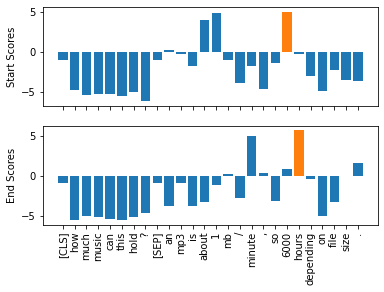

In [19]:
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [20]:

import torch 

start_idx = torch.argmax(start_logits)  
end_idx = torch.argmax(end_logits) + 1  
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


### tokenisation here? 

In [21]:

from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:323: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516246795654297,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082926332950592,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253460705280304,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [22]:
pipe(question="Why is there no data?", context=context, 
     handle_impossible_answer=True)

{'score': 0.906841516494751, 'start': 0, 'end': 0, 'answer': ''}

### Dealing with long passages


- dont want to truncate long answers, so apply a sliding window (`return_overflow=True`)


In [23]:
example = df.iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], 
                              return_overflowing_tokens=True, max_length=100, 
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [24]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 89 tokens


In [25]:

for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")
     

[CLS] does v9 license works with v8 platform? when i try to import the v9 license i am having this error. lic017. [SEP] idrac v9 license is not compatible with idrac v8 platforms. idrac license is tied with each system and you will not be able to install on another system other than the server it is intended. thanks, dell - shine k # iwork4dellview solution in original post [SEP] 



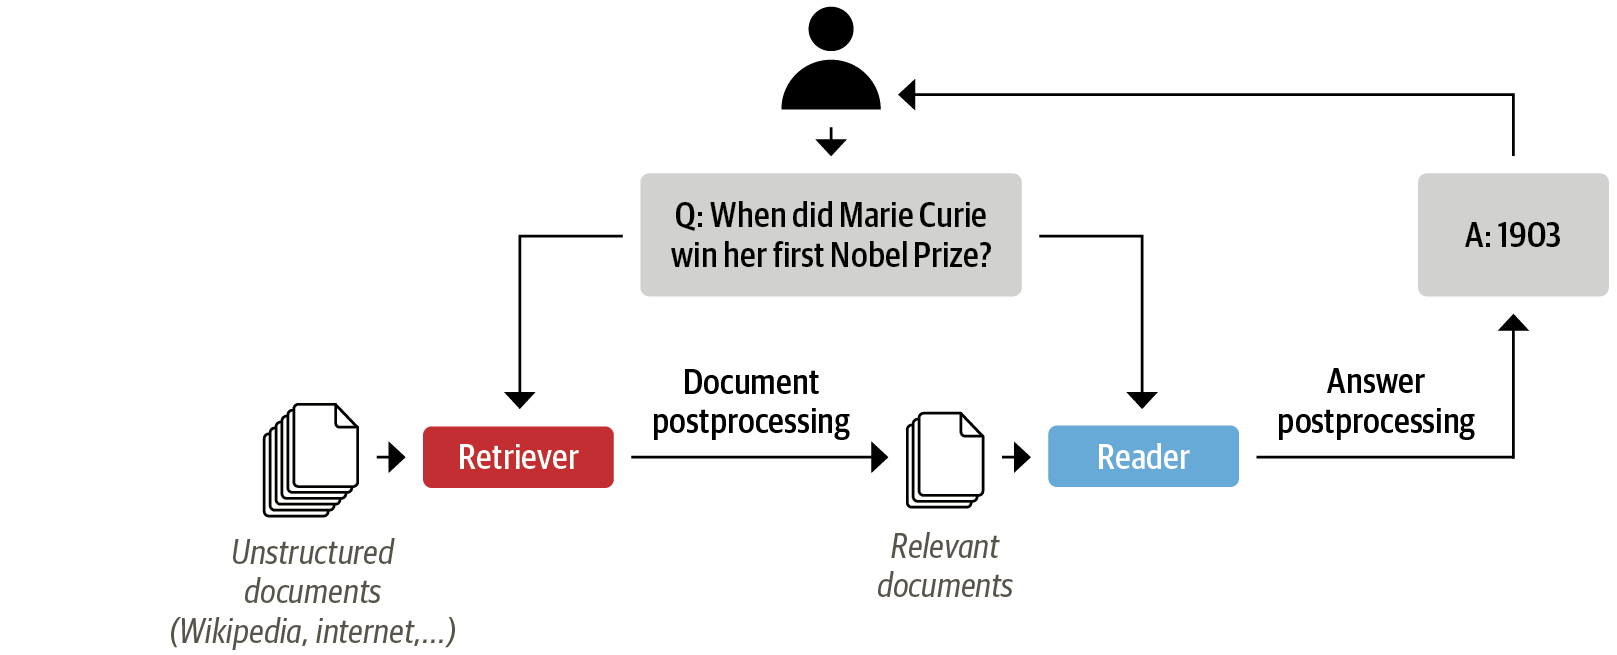

# ElasticSearch

```

url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-8.9.0-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-8.9.0-linux-x86_64.tar.gz



### had to:
1. !pip install --upgrade numexpr

1. pip install 'farm-haystack[elasticsearch]'
1. !sudo usermod -aG docker $USER
1. !sudo reboot


then ONLY use `lanuch_es()`

```

In [26]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-8.9.0-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-8.9.0-linux-x86_64.tar.gz

In [1]:
!sudo usermod -aG docker $USER

In [ ]:
!sudo reboot

In [2]:
!pip install --upgrade numexpr

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.7/381.7 kB 68.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Alternative if Docker is installed
from haystack.utils import launch_es

launch_es()
     

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
!curl -X GET "localhost:9200/?pretty"


{
  "name" : "510ce79d9e4e",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "qpebl8TGQMaAzopzzEoEYQ",
  "version" : {
    "number" : "7.17.6",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "f65e9d338dc1d07b642e14a27f338990148ee5b6",
    "build_date" : "2022-08-23T11:08:48.893373482Z",
    "build_snapshot" : false,
    "lucene_version" : "8.11.1",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [4]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever 
document_store = ElasticsearchDocumentStore(return_embedding=True)

/home/ubuntu/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [ ]:
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")
     

### convert df -> list and load to docstore

- populate `document` index with answers
- docstore expects a list of dictionaries and `meta` keys
- the fields in `meta` can be used to apply filers during retrival

- `dfs` SHOULD BE A SERIES OBJECT
- df should be a Dataframe object

In [102]:
print(type(df))


maybe i should keep more info in my df? anyways this below works I think

In [12]:
docs = []

# Iterate through the DataFrame, creating a dictionary for each row
for _, row in df.iterrows():
    doc = {
        'content': row['context'], 
        'meta': {}  # Optional: Add any additional metadata here
    }
    docs.append(doc)

# Add the documents to the DocumentStore
document_store.write_documents(docs, index="document")


/home/ubuntu/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


# Initalizing BM25 Reader..

In [13]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

In [14]:
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3)

In [15]:
print(retrieved_docs[0])


<Document: id=1a93a3494d130482abb1d9341f3a4642, content='With a KVM  you really will need to do some deductive troubleshooting.If port one is the only port w...'>


# Initializing a retriever (DPR) 


`from haystack.nodes import DensePassageRetriever`


In [16]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)


In [ ]:
document_store.update_embeddings(retriever=dpr_retriever)


# Initializing a reader

In [17]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2" #alternative larger models: deepset/roberta-base-squad2-distilled or deepset/xlm-roberta-large-squad2 or the tiny distilled model: deepset/tinyroberta-squad2
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)
     

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Pipe

In [77]:

from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=dpr_retriever)


     

In [78]:

n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3}, 
                                      "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")
     

Question: Is it good for reading? 

Answer 1: 
Review snippet: ...None...



Answer 2: yes, that's the fan that blows down on the memory sticks
Review snippet: ...yes, that's the fan that blows down on the memory sticks.View solution in original post...



Answer 3: I want to buy DDR3L HPE 647883-B21 16Gb DIMM ECC Reg PC3-10600 CL9This modules may not be supported.Kingston for Dell (317-6142 370-20147) DDR3 DIMM 16GB (PC3-10600) 1333MHz ECC Registered Low Voltage ModuleThis module can be used.
Review snippet: ....I want to buy DDR3L HPE 647883-B21 16Gb DIMM ECC Reg PC3-10600 CL9This modules may not be supported.Kingston for Dell (317-6142 370-20147) DDR3 DIMM 16GB (PC3-10600) 1333MHz ECC Registered Low Voltage ModuleThis module can be used....





/home/ubuntu/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


# Evaluating the Retriever

In [46]:
import json
from haystack import Label, Answer, Document

# Load data from JSON file
with open("Dell_QA_200.json", "r", encoding="utf-8") as file:
    data = json.load(file)

labels = []
for item in data["data"]:
    for paragraph in item["paragraphs"]:
        for qa in paragraph["qas"]:
            # Metadata used for filtering in the Retriever
            meta = {"item_id": qa["id"], "question_id": qa["id"]}
            
            # Extracting question and context information
            question = qa["question"]
            context = paragraph["context"]
            review_id = paragraph["document_id"]
            
            # Populate labels for questions with answers
            if len(qa["answers"]):
                for answer in qa["answers"]:
                    label = Label(
                        query=question,
                        answer=Answer(answer=answer["text"]),
                        origin="gold-label",
                        document=Document(content=context, id=review_id),
                        meta=meta,
                        is_correct_answer=True,
                        is_correct_document=True,
                        no_answer=False,
                        filters={"item_id": [meta["item_id"]], "split": ["test"]}
                    )
                    labels.append(label)
            # Populate labels for questions without answers
            else:
                label = Label(
                    query=question,
                    answer=Answer(answer=""),
                    origin="gold-label",
                    document=Document(content=context, id=review_id),
                    meta=meta,
                    is_correct_answer=True,
                    is_correct_document=True,
                    no_answer=True,
                    filters={"item_id": [qa["id"]], "split": ["test"]}
                )
                labels.append(label)


In [47]:
document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 237 question-answer pairs


In [49]:
print(labels[0])

<Label: {'id': 'ecb3d1d5-b888-40a9-b949-659a0e4178a4', 'query': 'Does v9 license works with v8 platform?When I try to import the v9 license I am having this error. LIC017.\xa0', 'document': {'id': '1619992', 'content': 'IDRAC v9 license is not compatible with iDRAC V8 platforms. IDRAC license is tied with each system and you will not be able to install on another system other than the server it is intended.Thanks,DELL-Shine K#IWork4DellView solution in original post', 'content_type': 'text', 'meta': {}, 'id_hash_keys': ['content'], 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'IDRAC v9 license is not compatible with iDRAC V8 platforms.', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_ids': None, 'meta': {}}, 'pipeline_id': None, 'created_at': '2023-07-31 17:18:52', 'updated_at': '2023-07-31 17:18:52', 'meta': {'item_id': 10

Next need to map question IDs and corresponding answers to pipeline, get all labels using FUNCTION BELOW:

In [50]:

labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

197


In [51]:
print(labels_agg[100])

<MultiLabel: {'labels': [{'id': '84b76851-7857-43a7-b3dc-6eba9bc19b7a', 'query': 'Dear all, have a nice day.Please inform me the part number or SKU number for "Dell 2TB 7.2K RPM NLSAS 12g/s 512n 2.5 inch (2 TB - NLSAS# 14G" for the following server:Power Edge VRTX-CH (Service tag <Service tag removed>)\xa0Best Regards,\xa0Manos Arvanitis<Add', 'document': {'id': '1619952', 'content': 'Hi,\xa0here are the three compatible drives part numbers:FVX7C HD,2TB,512N12,7.2K,2.5,S-AV,EC Hard DriveGH86F HD,2.0T,72KN,IS12,2.5,S-AV,EC Hard DriveTMVN7 HD,2.0T,722N,IS12,2.5,S-AV,EC Hard DriveLet me know if this helps.\xa0BRStefanStefan RichterCommunity\xa0ManagerBrand certified, SMaC ProfessionalView solution in original post', 'content_type': 'text', 'meta': {}, 'id_hash_keys': ['content'], 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'three compatible drives part numbers:FVX7C HD,2TB,512N12,7.2K,2.5,S-AV,EC H

In [60]:
def run_pipeline(pipeline, top_k_retriever=10, top_k_reader=4):
    for l in labels_agg:
        _ = pipeline.pipeline.run(
            query=l.question,
            top_k_retriever=top_k_retriever,
            top_k_reader=top_k_reader,
            top_k_eval_documents=top_k_retriever,    
            labels=l,
            filters={"item_id": [l.meta["item_id"]], "split": ["test"]})

In [61]:
run_pipeline(pipe, top_k_retriever=3)
print(f"Recall@3: {pipe.eval_retriever.recall:.2f}")

AttributeError: 'MultiLabel' object has no attribute 'question'

In [81]:
from haystack.pipelines import DocumentSearchPipeline

def evaluate_retriever(retriever, topk_values=[1, 3, 5, 10, 20]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=dpr_retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate metric for each top_k value
    for topk in topk_values:        
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")

bm25_topk_df = evaluate_retriever({"Retriever": bm25_retriever})


KeyError: 'Retriever'

In [72]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

KeyError: 'Reader'

# Evaluate the Reader

In [31]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")
     

EM: 0
F1: 0.8


In [32]:

pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


The evaluation of a reader can be done by creating a pipeline that consists only of a single node: a reader. In this case, the pipeline.eval() gets the relevant documents as direct input from the labels

# Domain Adaptation

- imporve Reader  by fine tuning MiniLM model further on SubjectQA
- `FARMREADER` has `train()` method designed for this purpose but expects SQUAD JSON format

In [34]:
!pip install farm-haystack[metrics]

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 115.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 104.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.1/114.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 196.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 74.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━

In [83]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

197


 we manually calculate the exact_match and F1 score by comparing the predicted answers with the ground truth answers. The compute_f1 function computes the F1 score between two answer texts, and the evaluate_reader function iterates through each question-answers pair and accumulates the scores. Finally, we compute the average exact_match and F1 score over all examples.
 
 https://docs.haystack.deepset.ai/reference/reader-api

In [127]:
from pathlib import Path
import torch

def train_and_evaluate():
    # Initialize model, optimizer, loss function, etc.
    train_filename = "Dell_QA_200_train.json"
    dev_filename = "Dell_QA_200_test.json"
    test_filename = "Dell_QA_200_test.json"  # or another test file
    data_dir = Path(".")  # using pathlib's Path
    save_dir = "./model"

    # Fine-tuning your model
    reader.train(data_dir=data_dir, use_gpu=True, n_epochs=1, batch_size=16,
                 train_filename=train_filename, save_dir=save_dir)

    # Evaluate the model
    result = reader.eval_on_file(data_dir=data_dir, test_filename=test_filename, device="cuda" if torch.cuda.is_available() else "cpu")
    print(result)

# Call the function to start the process
train_and_evaluate()


Train epoch 0/0 (Cur. train loss: 2.6390): 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]
FARMReader.eval_on_file() uses a slightly different evaluation approach than `Pipeline.eval()`:
- instead of giving you full control over which labels to use, this method always returns three types of metrics: combined (no suffix), text_answer ('_text_answer' suffix) and no_answer ('_no_answer' suffix) metrics.
- instead of comparing predictions with labels on a string level, this method compares them on a token-ID level. This makes it unable to do any string normalization (e.g. normalize whitespaces) beforehand.
Hence, results might slightly differ from those of `Pipeline.eval()`
.If you are just about starting to evaluate your model consider using `Pipeline.eval()` instead.
Evaluating: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

{'EM': 27.500000000000004, 'f1': 44.7551173010347, 'top_n_accuracy': 67.5, 'top_n': 4, 'EM_text_answer': 24.324324324324326, 'f1_text_answer': 42.97850519030778, 'top_n_accuracy_text_answer': 64.86486486486487, 'top_n_EM_text_answer': 32.432432432432435, 'top_n_f1_text_answer': 52.48132351665551, 'Total_text_answer': 37, 'EM_no_answer': 66.66666666666666, 'f1_no_answer': 66.66666666666666, 'top_n_accuracy_no_answer': 100.0, 'Total_no_answer': 3}


```
{'EM': 27.500000000000004, 'f1': 44.7551173010347, 'top_n_accuracy': 67.5, 'top_n': 4, 'EM_text_answer': 24.324324324324326, 'f1_text_answer': 42.97850519030778, 'top_n_accuracy_text_answer': 64.86486486486487, 'top_n_EM_text_answer': 32.432432432432435, 'top_n_f1_text_answer': 52.48132351665551, 'Total_text_answer': 37, 'EM_no_answer': 66.66666666666666, 'f1_no_answer': 66.66666666666666, 'top_n_accuracy_no_answer': 100.0, 'Total_no_answer': 3}

```

Below achieves the same but without metric tracking

In [116]:
train_filename = "Dell_QA_200_train.json"
dev_filename = "Dell_QA_200_test.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename,save_dir=".")

Train epoch 0/0 (Cur. train loss: 3.3364): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]
